<a href="https://colab.research.google.com/github/paulodowd/EMATM0054_53/blob/main/L2_LineSensors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Labsheet 2: Line Sensors


In this labsheet we will learn to operate the IR reflectance (line) sensors to detect black surfaces.  This labsheet will serve as a good model for how we might investigate a new sensor, develop code for the sensor, and then validate the operation.

On the 3Pi+ there are 5 sensors facing toward the surface. These sensors are **infra-red reflectance sensors**.  These are visible beneath the robot, as annotated in the following image:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53/blob/main/Images/3PI_BottomAnnotated.png?raw=true">
<br>
</p>

There are actually **2 ways we can operate these sensors**.  
- **Approach 1 (ADC)**: Using the `Analog to Digital Converter` (ADC) to measure the voltage passing through the sensor phototransistor.
- **Approach 2 (Digital)**: Using an internal timer to measure the discharge of a capacitor in the sensor.









<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/tick.png" align="left">  Either approach 1 or 2 can be used to complete Assessment 1.  You are encouraged to first of all pursue a **minimum viable product** for Assessment 1, and then come back later to improve your solution.  Therefore, it is fine if you only complete the exercises for Approach 1 and then come back later.

<hr><br><br><br><br>



# Approach 1 (ADC): Analog-to-Digital Converter, Theory

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/theory.png" align="left"> The <a href="https://www.pololu.com/docs/0J83/5.5">official documentation for the Pololu 3Pi+</a> describes the second approach in this labsheet to read the sensors (using an internal timer to measure the discharge of the sensor capacitor, next section of this Labsheet).  However, it is possible to set some special configuration within the microcontroller to allow for a simpler sensor reading operation using the `Analog-to-Ditigal Converter` (ADC).   This is not the way Pololu appeared to have intended when designing the sensors and circuitry.

<p align="center">
<br>
<img width="50%" src="https://github.com/paulodowd/EMATM0054_53/blob/main/Images/3PI_DN_ReflectanceHalf.png?raw=true">
<br>
</p>

The general theory of operation for the line sensors is that they:
- emit infra-red (IR) light downward, which strikes the surface and reflects back.
- photo-diodes are used to make a measurement of the intensity of the reflection.

In Arduino, reading an analogue voltage is almost as simple as using one line of code: `analogRead()`:

```c
  // Somewhere to store the result
  int my_adc_read;

  // read the sensor, attached to pin 'A0'
  my_adc_read = analogRead(A0);
```



When calling this `analogRead()`, an internal peripheral called the `ADC` will be instructed to operate.  The ADC will attempt to compare the voltage on a specified pin of the microcontroller against a reference voltage source.  We can only use the `ADC` on specific pins, and these are labelled within Arduino as `A0`, `A1`, `A2`, etc.  Within our 3Pi+, the reference voltage is configured as the 5volt supply by default.  So the next logical step is to find out which pins the line sensors are connected to.

<p align="center">
<img src="https://github.com/paulodowd/EMATM0054_53/blob/main/Images/3PI_PololuPinAssignments_LineBump.png?raw=true">
</p>

The <a href="https://www.pololu.com/docs/0J83/5.9">Pololu documentation on pin assignment</a> lists the following:
- `A11`, Line Sensor 1 (DN1, leftmost)
- `A0`, Line Sensor 2 (DN2)
- `A2`, Line Sensor 3 (DN3, centre)
- `A3`, Line Sensor 4 (DN4)
- `A4`, Line Sensor 5 (DN5, rightmost)

In the above, `A11`, `A0` (etc) are Arduino specified pin names.  These are used as a type of "find and replace" so that the code you write within Arduino could be used on different microcontrollers.  This is why it is important that you select the correct `Board` (for us, Arduino Leonardo) when using the Arduino IDE.  The Arduino IDE will take `A0` (for example) and map it to the actual hardware pin (`PF7`, "port F bit 7", <a href="https://www.pololu.com/docs/0J83/5.9">according to the Pololu documentation</a>).  Sometimes, you will see that a single pin will have more than one Arduino pin name.  As above, `A0` is also referred to as `18` - here, a good general rule is to use the `An` pin names when reading analogue pins, and otherwise use the numbered names (e.g. `18`) for all other digital operations.

If we go ahead and try to make an `analogRead()` of the line sensors it won't work.  You could try the following code:

```c

// The pin used to activate the IR LEDs
#define EMIT_PIN 11

void setup() {
   
   // configure the central line sensor pin
   // as input.
   pinMode(A2, INPUT);

   // Configure the EMIT pin as output and
   // high.  This will active some infra-red
   // (IR) LEDs for our sensors to read.
   pinMode( EMIT_PIN, OUTPUT );
   digitalWrite( EMIT_PIN, HIGH );

   // Configure the Serial port
   Serial.begin(9600);

}

void loop() {

   // A variable to save a reading
   int dn3;
   
   // Use ADC, assign result to variable
   dn3 = analogRead(A2);
   
   // Report back to computer over Serial
   Serial.print( dn3 );
   Serial.print( "\n" );

   delay(100);
}

```

You should find on Serial Monitor the reported values:

```
0
0
0
0
```

Why is this?  We can find the electronic schematic on the Pololu website (<a href="https://www.pololu.com/product/4975/resources">available here</a>) to try to understand why:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53/blob/main/Images/3PI_BumpSchematic.png?raw=true">
<br>
</p>

The above is actually for the bump sensors, but they are electronically very similar to the line sensors, and provide a simpler schematic to inspect.  The leftmost portion with components `D9` and `D10` is the emitter circuit, which will provide the infra-red (IR) light to detect.  In the above, let's consider the middle section of the schematic, looking at each label:
- **5V**: this is the supply voltage shared with the 3Pi+ devices.
- **C53**: this is a capacitor, a bit like a tiny battery that can be charged and discharged.
- **Q10**: this is a photo-transistor.  It is a bit like a switch or valve that goes between `on` and `off`, determined by the amount of light hitting it (indicated by the little arrows pointing toward it).
- **R52**: this is a resistor, and will restrict the amount of current (flow) through the microcontroller, providing it some protection.
- **BUMPL**: this is the pin label used in the electronic schematic - another different label!  This can be matched up on page 1 of the schematic to D4, then PD4 of the microcontroller - an ADC pin.  Sometimes we have to do some detective work.
- ⏚ : this is the "ground" symbol, which is equivalent to 0 volts, and will complete the electronic circuits.

What we want to do is to measure the voltage received into `BUMPL` through `R52`.  What we want is to be able to sample the voltage between `C53` and `Q10` as if it was a <a href="https://studymind.co.uk/notes/potential-dividers/">potential divider</a>, but in the default configuration we cannot do it.

At the moment, when the 3Pi+ is powered on, the two sides of the capacitor
accumulate their respective charge, reach an equilibrium and becomes "fully charged".  Once this has happened, the capacitor appears to have the same voltage as the supply voltage (5v) - so between the 5v supply and `C53` there is no potential difference.  Because there is no potential difference, the capacitor `C53` ends up "blocking" the 5V source, from the point of view of `BUMPL`.   Therefore, `BUMPL` is only measuring ground (0V, ⏚) through `Q10`.  

To achieve a potential divider circuit, we can actually tell the Arduino to activate some internal circuitry (<a href="https://docs.arduino.cc/learn/microcontrollers/digital-pins/#pullup-resistors-with-pins-configured-as-input">in the Arduino reference here</a>).  Our example code becomes:

```c
//
// Example code to read A2 (line sensor DN3),
// using the ADC.
//

// The pin used to activate the IR LEDs
#define EMIT_PIN 11

void setup() {
   
   // configure the central line sensor pin
   // as input, and also activate the
   // internal pull-up resistor.
   pinMode(A2, INPUT_PULLUP);

   // Configure the EMIT pin as output and
   // high.  This will active some infra-red
   // (IR) LEDs for our sensors to read.
   pinMode( EMIT_PIN, OUTPUT );
   digitalWrite( EMIT_PIN, HIGH );

   // Configure the Serial port
   Serial.begin(9600);

}

void loop() {

   // A variable to save a reading
   int dn3;
   
   // Use ADC, assign result to variable
   dn3 = analogRead(A2);
   
   // Report back to computer over Serial
   Serial.print( dn3 );
   Serial.print( "\n" );

   delay(100);
}

```

Can you spot the difference?  The below diagram illustrates what this small adjustment to the code does electronically:

<p align="center">
<img src="https://github.com/paulodowd/EMATM0054_53/blob/main/Images/3PI_InputPullUpSchematic.png?raw=true">
</p>

On the left portion of the above schematic, the big yellow block labelled `Atmega32u4` is the microchip that is our microcontroller.  It has many more pins connect to other things, but these have been left out for simplicity.  Inside the `Atmega32u4` is illustrated the internal peripheral `Analogue-to-Digital Converter (ADC)`.  We can see that the same sensor circuit discussed earlier is attached to the point labelled `BUMPL`.

When we use the line of code `pinMode( A8, INPUT_PULLUP )` (for the circuit above, for example), we tell the microcontroller to activate a resistor inside the chip attached to pin `A8`, changing the overall electronic circuit.  This has been labelled `internal pullup resistor`.

The right portion of the above schematic is the same electronic ciruit, but reconfigured to discuss.  `C53` has been included, but let's ignore it carrying our assumption that it effectively blocks it's 5V source.  The internal pullup resistor is effectively bypassing the blocking capacitor `C53`.  Looking at the right portion, we can now see that a potential divider exists:
- The top half, following: `5V` through `internal pullup resistor`.
- The bottom half, `R52` and `Q10` connected in series to ground (`⏚`).  
- Our `BUMPL` pin is going to be measuring at the point between the two.

In this configuration, current can now flow from a 5V source to ground (⏚). through `internal pullup resistor`, `R52` and `Q10`.   The phototransistor `Q10` will now act like a variable resistor (changing it's resistance), restricting the current flow dependent on the light striking it.  Because we have current flowing, a complete circuit, we can now measure a changing analogue voltage at point `BUMPL`.


<hr><br><br><br><br>



## Exercise 1: Reading the Line Sensors (ADC).

For these exercises, review the **code stub** available on Github ( ).  In particular, you will need to work with `LineSensors.h`.  




<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/exercise.png" align="left">  You should review the `LineSensors.h` file specifically.  You will find some functions whose names are suffixed with `ADC`.  You will need to complete all areas within these functions marked with `????`.  You will need to `uncomment` code by removing the `//` (comment syntax) text.  


1. Review and complete the function `initialiseForADC()`.  All the information you need is in the theory section above.
2. Review and complete the function `readSensorsADC()`. All the information you need is in the theory section above.


 <img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/validate.png" align="left">  **Validate:** To check the sensors are reading correctly, the best approach is to use the **Serial Plotter**.  This allows you to see if there is a meaningful response - for example, the readings should change when you move the robot across a black and white surface.  The assessment map has plenty of black and white surfaces you can use.

  




-  After updating `LineSensors.h` to read `DN1`, `DN2`, `DN3`, `DN4` and `DN5`, use the `Serial.print()` commands to report the sensor readings all on one line, seperated by commas.  Producing comma seperated values will allow you to use the Arduino Serial Plotter to visualise the data on a plot.  
- You will need to make repating calls to `Serial.print();`, once for the variable and then again for the text string `","` - see example below.
 - For each set of data (probably, each `loop()`), remember to end with a newline (`"\n"`) - see example below.
 - **Note:** If you Serial Print anything other than comma seperated values, the Serial Plotter will not work properly (e.g. text will make it go weird)
 - **Note:** For Serial Plotter to work properly, you want to report the same number of variables on each line - this will become different coloured line plots.  (e.g., providing 3 comma seperated values, repeating line by line)

 ```c
 // Formatting for comma seperated values allows for
 // Serial Plotter to visualise data as coloured lines.
 // E.g. 2.1, 3.5, 4.7\n
void loop() {
    // Get latest readings.
    line_sensors.readSensorsADC();

    // Access the updated readings variable within the
    // line_sensors class instance.
    Serial.print( line_sensors.readings[0] );
    Serial.print( "," );
    Serial.print( line_sensors.readings[1] );
    Serial.print( "," );
    Serial.print( line_sensors.readings[2] );
    Serial.print( "\n" );     // finish with a new line (\n)

    delay(20);
}
```

If done correctly, each sensor should be a different coloured line on the Serial Plotter:
<img  src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/Plotter_ADC_LineSensor.jpg">

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/observation.png" align="left"> **Observations:** Take some time to reflect on what you have observed. You may have noticed some of the following statements. For each of the below, consider what the impact or consequence may be in our task of navigating an area bordered by a black line.



- The sensor readings are never 0.  In fact, they almost always have a lowest value of 600 and upwards.
  - We learn from this that even though the ADC is 10-bit, and therefore has a maxmimum of 1024 possible values, the sensor is only working in a small subset. Therefore, reading the line sensors through the ADC must have a resolution much lower than 10-bit.
  - Can you work out, approximately, the mimimum number of bits that could be used to capture your line sensor range?
- Each of the line sensors has a generally different value, even though the robot was placed on a consistent white surface.
  - From this, we observe that whilst the sensors respond in a similar way, each sensor has different systematic bias.  Even if reality was "constant", the sensors might not be.
- The sensor values even change if I wave my hand around above the robot, or if I lift the robot up.
  - From this we learn that the sensors are sensitive to the external environment.  
  - The sensors work by measuring reflected IR light.  IR light also exists in the world around us.
  - It is important to appreciate the quantity of IR light in the environment can also vary.  Therefore, if you change room, your robot might behave differently.
- From discussion with my peers, I notice the sensor values are different between each robot.
  - From this, we learn that we could invest a lot of time and effort in making code work for our (my) robot, but it wouldn't necessarily work for another robot.
  - It would be much better to use some code to **standardise** or **normalise** the sensor readings.



<hr><br><br><br><br>

## Exercise 2: Write a Calibration Routine

A calibration routine is usually applied when a robot or system activates to capture the performance or configuration of the system.  For example, it is a common requirement to activate a drone (unmanned arial vehical, UAV) on a flat level surface, so that it can capture effects on the sensor whilst the robot is stable and not moving.  This happens just once when the drone is activated.  After which, the information that was gained through calibration is then applied to future readings.  

Similarly, our calibration will have **two components**.  
- A "run once" routine to capture the `minimum`, `maximum` and therefore `range` of each sensor.
- A function to apply the calibration factors (registered in calibration) to all later sensor readings.


In our system, we want the robot to experience both a black and white surface to understand what the `minimum`, `maximum`, and therefore `range` of each line sensor is.  The map provided for assessment has a patch of alternating black and white at the start location (illustrated below).  Therefore, we simply require the robot to rotate on the spot for enough time for the sensors to pass over black and white.

<p align="center">
<img width="100px" src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/calibration_disk.png"> </p>


For this exercise there is no template code provided for you.  However, you can draw on the code from Labsheet 1 to operate your motors, and the code from the previous exercise to read the line sensors with the ADC.  

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/info.png" align="left"> **Information:** It might feel like that a calibration is a lot of effort for little return.  This is not true.  In fact, the time spent adjusting hard-coded values in your code when you change room, or whether the sun is shining or not, will result in a lot of wasted time and frustration.  Sometimes it is best to invest some effort early to save time later.

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/exercise.png" align="left">  **Exercise:** At the top level of your program - either within `setup()` or within a newly defined function called from `setup()`, write a routine that will cause your robot to rotate on the spot whilst making sensor readings.  This can be achieved in many ways.  For example:

- You could start the robot rotating via `motors.setPWM( , );` then call a new function within your `line_sensors` class that will iteratively take readings.  Whilst it is taking these readings, the robot will keep rotating.  When your function within `line_sensors` finishes and returns to `setup()`, you then call `motors.setPWM( 0, 0 );` to stop your robot rotating.
- You could complete both rotation commands and sensor reading within `setup()`, and then set the calibration values into your `line_sensor` class either using a function or directly, such as `line_sensors.maximum[n] = ????;`, where n is a value [0:4] (sensors 0 to 4).

Review the following pseudocode for capturing the `minimum`, `maximum`, and `range` before continuing:
<p align="center">
<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/pseudocode_calibrate_linesensors.jpg">
</p>

1. To complete this task, you could use an iterator like `for(;;){}`, `while(){}`, or `do {} while()`.  Write some code that has your robot rotate on the spot for a pre-determined amount of time, and then stop.
  - Decide which motor power value to use.
  - Decide how long the robot should rotate for.  You can come back and change this later.  If you are using an iterator, the total time spent rotating will be determined by the maximum count of iterations and any delay used.  
  - Check that your robot can rotate, then stop.

2. Write some code to update the variables `maximum[ <sensor index> ]`, and `minimum[ <sensor index> ]` whilst your robot rotates and collects new readings. You can review the pseudocode above for how to achieve this.  You will need to translate pseudocode into code for Arduino - a valuable skill.
  - Initially, you will need to set the `maximum[]` variables to a very small value.  This is because we will want to compare a new reading against `maximum[]` and update `maximum[]` if the new reading is larger.
  - If you are writing a calibration routine from `setup()`, after you have called `line_sensors.readSensorsADC();`, you can access the readings using `line_sensors.readings[n];`, where n is a value [0:4] (sensors 0 to 4).
  - If you are writing a function witin the `LineSensor_c` class defintion, you can access the `readings[]`, `minimum[]`, `maximum[]` variables directly.
  


<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/validate.png" align="left"> **Validate:** Once you have the above implemented, it is important that you use the **Serial Monitor** to check that your calibration is capturing values for `minimum`, `maximum` and `range` that look sensible.

  - Just for temporary debugging, add some code after your calibration routine that will continously report the calibration values over Serial.  You could achieve this in `loop()`.  Therefore, you should see your robot rotate whilst it calibrates, then stop - at which point it will have finished `setup()` and moved into `loop()`.
  - Note that, you can download your code to the 3Pi robot, unplug the USB cable, then use the motor power button to activate the robot.  When it stops, you can plug the USB cable in again to review the output on the Serial Monitor.

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/exercise.png" align="left"> **Exercise:** Once you have a calibration routine to capture the `minimum`, `maximum` and `range`, we can write a function to apply these calibration values to your sensor readings.  Applying these calibration values will become our "normal sensor reading process", because the sensors will be much more consistent with each other, and there more convenient and useful.
 First, review the pseudocode below.
<p align="center">
<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/pseudocode_apply_calibration_linesensors.jpg">
</p>

1. The `LineSensors.h` file has an incomplete function called `calcCalibratedADC()`.  Complete this function using the pseudocode above as a reference.
  - Previously, we noted that all the sensor readings typically started from a value at 600 or higher.  In the pseudocode, the line part $Readings_{n}$ - $Min_{n}$ functions to remove this systematic bias of the sensor, causing all sensor readings to begin from 0.
  - The element that reads $/Range_{n}$ is dividing this present sensor reading (minus the bias) by the maximum total range, which will *normalise* this reading to a value between 0 and 1.  This should be familiar to you as a part of the operating of working out a percentage.


 <img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/validate.png" align="left">  **Validate:** As before, use the **Serial Plotter** to now check how your line sensor readings appear.  You want to use your new `calcCalibratedADC()` function, and access the `calibrated[]` variables.   You may notice that your values do sometimes exceed [ 0.0 : +1.0 ] - it is important to **analyse** and **evaluate** for yourself if the magnitude of this is significant - do you think it will effect the performance of your system?

  ```c
void setup() {
  // Remember to run your calibration routine!
}

 // Formatting for comma seperated values allows for
 // Serial Plotter to visualise data as coloured lines.
 // E.g. 2.1, 3.5, 4.7\n
void loop() {
    // Get latest readings.
    line_sensors.calcCalibratedADC();

    // Access the updated readings variable within the
    // line_sensors class instance.
    Serial.print( line_sensors.calibrated[0], 4 );
    Serial.print( "," );
    Serial.print( line_sensors.calibrated[1], 4 );
    Serial.print( "," );
    Serial.print( line_sensors.calibrated[2], 4 );
    Serial.print( "\n" );     // finish with a new line (\n)

    delay(20);
}
```

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/info.png" align="left"> **Information:** In the above example, notice that `Serial.print()` has been used with an extra argument, `, 4` - so it looks like `Serial.print( line_sensors.calibrated[0], 4 );`.  This extra argument means that the Serial Print command will print 4 decimal places - a number like `0.0001`.  This is useful to remember when debugging!  Sometimes it will look like a number is not changing - but you just don't have enough decimal places (it is 2 by default).

<hr><br><br><br><br>

## Exercise 3: Write an Obstacle Avoidance Behaviour.

We now have the core components required for the 3Pi+ robot to navigate the coursework map without leaving the area defined by the black border.  

<p align="center">
<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/linesensors_turning.png">
</p>

The above illustration indicates where the line sensors are positioned on the robot.  In the smaller illustration below, the robot has encountered a black line in various positions, activating different sensors.  There are more possible combinations of sensor activation.  Decide which set are most important, and whether any sensor has a particular priority.  

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/hypothesis.png" align="left">**Hypothesise:** If the robot was to detect a black line on all sensors simultaneously, what would be the better action to take?  How could your robot be programmed to avoid an oscillating (repeating) behaviour?  For example, we can imagine the robot reverses, and then drives forwards again, and then repeats.

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/exercise.png" align="left">  **Exercise:** For this exercise, you will need to combine code from this labsheet and previous labsheets.  

1. Write a new function within `LineSensors_c` (`LineSensors.h`) that will return `true` or `false` depending on whether a requested sensor is over a black surface.  You could also write a function that returns true or false if any sensor is over a black surface.
  - You could use a function declaration like `bool isOnLine( int which_sensor ){}`, which uses either `return true;` or `return false;` depending on the value of a sensor specified.
  - You could use a function declaration with no argument, like `bool isOnLine(){}` which returns `true` or `false` if any sensor is on a line.
  - Depending on whether you have implemented a calibration routine, decide a threshold value that signifies that the sensor is over a black surface.  
    - If you have used calibration which will be a value between [0.0 : 1.0 ] for all sensors. You will need to compare the latest sensor reading against this threshold value for your robot to make a decision.

2. Within `loop()`, write a simple `if()` statement to capture whether any sensors are currently over a black surface.  
  - When this statement evaluates as `true` (there is a line), call your `setTurn()` function with a duration to have the robot turn away from the black line a sufficient amount.
  - Decide whether you should use a different call to `setTurn()` for each of the line sensors.

4. Follow the following syntax to test the ability of your robot to avoid the black boundary of the map area:

```c

void setup() {
  // ...
}

void loop() {

  // SENSE: Check sensors
  // If true, we have hit the boundary box
  if( line_sensors.onLine() == true ) {

    // Trigger a turn of n milliseconds
    setTurn( ???? );
  }

  // PLAN: what is the robot currently doing?
  // Is the robot doing a turn operation?
  // checkTurn() will return true of false
  bool turn_status = checkTurn();

  if( turn_status == false ) {// i.e. not turning

      // ACT: Code to drive forwards
      

  } else { // i.e., robot is turning

      // ACT: robot is set to turn, so
      // nothing to do here currently.  
      
  }

} // End of loop()

```


<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/info.png" align="left"> **Information:** In the above code extract, we currently "do nothing" whilst the robot is turning.  In the future, we may need to actually check for the presence of the magnet and the black line bounding the search area.  This should be relatively straight-forward to implement, because the recommended code above is non-blocking.

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/observation.png" align="left"> **Observations:** Take the time to observe how your robot performs in a variety of different circumstances.  Try positioning your robot at different angles relative to the black line.  Observe how often your robot is sucessful.  Consider what may be going wrong when something doesn't work. Remember that your robot can beep, or activate the LEDs, to give you some indication of what it is doing.

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/validate.png" align="left"> **Validate:** In this exercise, we are using a fixed threshold value to determine whether a line sensor is over a black line or not.  Conduct some tests to validate how robust and reliable your threshold value is.  Try using a light source to interfere with the operation of your robot.  Try using your robot in a room with windows and daylight.

<hr><br><br><br><br>

<hr><br><br><br><br>

# Advanced Exercises:

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/tick.png" align="left">  At this point in the labsheet, you can decide to move to the next labsheet and come back to this one later.  Either Approach 1 or Approach 2 can be used.  You are encouraged to first get a **minimum viable product** to solve the assessment, and then come back to improve it later.



## Approach 2 (Digital): Using time, Theory of Operation

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/theory.png" align="left">  The line following sensors operate by transmitting a beam of infra-red light and sensing the intensity of the reflection.  On the 3PI+ circuit board you can see them labelled as `DN1`, `DN2`, `DN3`, `DN4`,  and `DN5`.  The **`transducer`** in this sensor is a photo-transistor - a transistor whose operation is effected by light.  

<p align="center">
<br>
<img width="50%" src="https://github.com/paulodowd/EMATM0054_53/blob/main/Images/3PI_DN_ReflectanceHalf.png?raw=true">
<br>
</p>

The 3Pi+ line sensors (and bump sensors) are intended to work by timing the discharge of a capacitor.  The circuit for the bump sensor is easier to review - we will review this to understand how these sensors work:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53/blob/main/Images/3PI_BumpSchematic.png?raw=true">
<br>
</p>

In the above schematic for the 3Pi+ bump sensors  (page 3, in the <a href="https://www.pololu.com/file/0J1790/3pi-plus-32u4-control-board-schematic.pdf">electronic schematic</a>), we can see 3 principle circuits.  On the far left are infra-red `Light Emitting Diodes` (`LEDs`).  These are enabled or disabled in software.  If they are disabled, the sensor will be behaving under `ambient light` conditions - whatever IR light exists in your working environment.  The two circuit components on the right are the detecting circuits.  The general form of this circuit is repeated for the 5 ground facing sensors.  

The detecting circuits utilise a photo-transistor in a small electronic circuit to control the rate of charging and discharging of a capacitor.  The photo-transistor (labelled `Q10` and `Q11` above) is the **`transducer`** in the sensor, the element converting energy from one form to another - the light (photon energy) exposure attenuates the (electron energy) activation of the photo-transistor.  In this circuit, we can imagine that the photo-transistor is restricting the electron flow of the circuit to varying degrees depending on the light conditions.  It might be useful to think of a capacitor (labelled `C53` an `C54` above) as a very small battery which can be charged and discharged quickly.  

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53/blob/main/Images/3PI_IRDischarge.png?raw=true">
<br>
</p>

Varying the IR light on the photo-transistor will change the time it takes for the capacitor to discharge.  Whilst the discharge of the capacitor is a continuous analog signal, a `digitalRead()` will register either `HIGH` or `LOW` depending on the voltage of the capacitor with respect to a logic threshold voltage.  We always expect digital logic to work in this way, and it is a characteristic which makes digital electronic circuits robust to `signal noise`.  

In the above illustration, we can observe how a slower discharge means more time will elapse before `digitalRead()` registers a `LOW` state.  Therefore, the exposure of the photo-transistor to IR light is represented by the `time` taken for the capacitor discharge to transition from logic `HIGH` to logic `LOW`.  On the left, `dt` is 1000 microseconds (slow discharge), whilst on the right `dt` is 100 microseconds (fast discharge).  These are example values.

This process might seem unnecessarily complicated.  A reasonable question would be, "why not use the ADC?" or, "why measure the time of discharge?".  The answer is that microcontrollers typically have a small number of `ADC` **`channels`**, or pins to take analog measurements.  Furthermore, the 3Pi+ has been designed to use every single pin available on the 32u4 microcontroller, and so some compromises were necessary in the design.  By instead measuring the time taken for a capacitor discharge, a general purpose `digital pin` (normally binary, 0 or 1) can be be used.  Whilst a digital pin is used, the method retains a continuous measurement of the sensor.  

### A Final Detail:

The design of the 3Pi+ uses some techinques to re-use digital pins for different functions.  The line sensor and the bumpers both require IR LEDs to be enabled, but it is desirable that their respective IR light transmission does not interfere with each other.  A single 32u4 `GPIO` pin has been used to enable and disable the IR LEDs for line sensors and bump sensors independently:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53/blob/main/Images/3PI_LineSensorEMIT.png?raw=true">
<br>
</p>

In the circuit extract above (<a href="https://www.pololu.com/file/0J1790/3pi-plus-32u4-control-board-schematic.pdf">electronic schematic</a>) the IR LED circuit for the line sensor and bump sensor are placed next to each other.
- On the left, we see that the `EMIT` connection is used to `sink` (act as ground, 0v) the supply from 5v through the IR LEDs.  This is achieved in software by setting the `EMIT` pin to an `OUTPUT` with `LOW` output.  
- On the right, we see that the `EMIT` connection is used to `source` 5v through the IR LEDs to the circuit ground, 0v.  This is  achieved in software by setting the `EMIT` pin to an `OUTPUT` with `HIGH` output.  

This circuit works because diodes (including light emitting diodes) can only function in one direction of an electronic circuit.  

To disable the IR LEDs for both the line sensor and the bump sensor, we use the 32u4 to turn the `EMIT` pin into an `INPUT`.  This neither provides 5v or grounds the circuit properly, and the IR LEDs cannot activate properly.  In this way, we can achieve three states from a digital pin.











<hr><br><br><br><br>

## Exercise 4: Reading a Line Sensor (digital)

Let's review the following pseudocode of the sensor operation to get an overview of what to expect:

<p align="center">
<br>
<img src="https://github.com/paulodowd/EMATM0054_53/blob/main/Images/Algo1_ReadLineSensors.png?raw=true">
<br>
</p>



Reading Algorithm 1 above, (remember you can also review details in the <a href="https://www.pololu.com/docs/0J83/5.5">3Pi+ documentation</a>), we can summarise the following programming instructions required to utilise the infra-red sensors to measure IR light reflected from the 3Pi+ work surface:
1. Set the infra-red LEDs to be enabled, to transmit infra-red light to reflect off the work surface.  
2. Set the sensor measurement pin to an `OUTPUT` with state `HIGH`.  This will produce a positive voltage to charge the capacitor.  
3. Wait for 10microseconds for the capacitor to charge to full.
4. Set the sensor measurement pin to an `INPUT`.  The capacitor we have charged now begins to discharge.
5. Capture the current time in microseconds ($t_{start}$), representing the beginning of the sensor reading process.
6. Wait for `digitalRead()` on the sensor measurement pin to change to `LOW` as the capacitor continues discharging.  No code is occurring here, so this is computationally inefficient.  You might want to fix this later.
7. Once `digitalRead()` has change to `LOW`, we exit the while loop.
8. Capture the current time in microseconds ($t_{end}$), representing the end of the sensor reading process.
9. Set the infra-red LEDs to be disabled (off).  Note that this is done by setting the EMIT pin mode to INPUT, which was discussed earlier.
10. Return the result, the time elapsed to conduct the sensor reading, $t_{elapsed}$.

This might seem like a lot to achieve - so we will start at the beginning and keep it simple.

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/exercise.png" align="left">  **Exercise:** To begin with, save your previous work with the 3Pi+ and create a new blank sketch.  When we are developing for new hardware we want to keep the process as simple and as error free as possible.  Therefore, for now we do not need any code relating to the operation of the motors (Labshseet 2).  We will also set ourselves the following objectives:

- Work with just one sensor, let's use `DN1`.
- Write our first sensor reading program inside `loop()` (you can refactor this into the class `LineSensors_c` later).
- Make sure we can get 1 sensor to work, before trying the rest.


Using the below template code, complete the following:

1. Update the abive code within `setup()` and `loop()`:
  - Fix any elements labelled `????`
  - Find any missing steps, add comments to help you keep track of what has been completed.


```c
#define EMIT_PIN    11    // Documentation says 11.
#define LS_LEFT_PIN ????   // Complete for DN1 pin


void setup() {

  // Set some initial pin modes and states
  pinMode( EMIT_PIN, INPUT ); // Set EMIT as an input (off)
  pinMode( ????, INPUT );     // Set line sensor pin to input

  // Start Serial, wait to connect, print a debug message.
  Serial.begin(9600);
  delay(1500);
  Serial.println("***RESET***");

} // End of setup()


void loop() {

  // Complete the steps referring to the pseudocode block
  // Algorithm 1.
  // The first steps have been done for you.
  // Fix parts labelled ????
  // Some steps are missing - add these.
  pinMode( EMIT_PIN, OUTPUT );
  digitalWrite( EMIT_PIN, HIGH );


  pinMode( ????, OUTPUT );
  digitalWrite( ????, HIGH );
  delayMicroseconds( 10 );
  
  // Capture start time in microseconds
  unsigned long start_time = micros();

  // Wait for the sensor pin to go low
  while( digitalRead( ???? ) == ???? ) {
      // Do nothing here (waiting).
  }

  // Capture end time in microseconds
  unsigned long end_time = ?????;

  // Turn of IR LEDs
  pinMode( ?????, INPUT );

  // Work out the difference in time
  unsigned long elapsed_time = end_time - start_time;

  // Print what this sensor measurement was
  Serial.println( elapsed_time );

} // End of loop()


```







<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/observation.png" align="left"> **Observations:** What happens if you leave `EMIT_PIN` set as an `INPUT` (and at no point in your code make it an `OUTPUT`, `HIGH`)?  Use the `Serial Monitor` to investigate what value is reported.  What is happening, why does it work?
  


2. Where we are using `while( digitalRead( ???? ) == ???? ) `, there is a chance that something has gone wrong, and your sensor will never transition to a `LOW` value.  This would mean your code (and robot) would be stuck in this while loop forever.  You can safe-guard against this by implementing a time-out check.
  - Within the `while` loop, write an `if` statement that checks how much time has elapsed ($t_{end} - t_{start}$), and if it is too large, it finishes the sensor reading.
  - What value of time elapsed would be suitable as "too large"?
  - What value should the sensor reading return if this time-out condition occurs?
  - Decide how to end your while loop.  You can force a while loop to end by:
    - using the `break;` command.
    - adding another condition to the while loop.
    - forcing an existing condition to become true.
    - using the `return` call to leave the function.


<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/validate.png" align="left"> **Validate:** Validate that your time-out sequence is operating by setting `EMIT_PIN` to an `INPUT`.  

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/exercise.png" align="left">  **Exercise:** Once you have the above code working to read one of the line sensors, refactor your code from `setup()` and `loop()` into functions within the `LineSensors_c` class template.  

1. Integrate your digital sensor read routine into the `LineSensors_c` class template.  Some function declarations have been prepared for you, but you can specify your own.
2. Adapt your code so that any of the 5 line sensors (`DN1`, `DN2`, `DN3`, `DN4`, `DN5`) can be used.
3. Write a function that will perform a read of all line sensors by simply iterating and making a call to your sensor read function.  For example, a function names `digitalReadAllSensors()` which calls `digitalReadSensor(int which)` 5 times, once for each sensor.
4. Test that you are able to use your digital line sensor read functions from `loop()` through the class construct (e.g., `line_sensors.digitalReadAllSensors();`.


<hr><br><br><br><br>

## Exercise 5: A Calibration Routine

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/exercise.png" align="left">  **Exercise:** In Exercise 2 for the ADC method of reading the line sensors, you implemented a calibration routine.  Implement a calibration routine for this digital read approach to the line sensors.  Your overall goals are the same, and the same pseudocode provided previously applies:



1. If possible, re-use your calibration routine for the ADC approach to reading the line sensors.  Therefore, your robot should rotate and collect sensor readings across the black and white calibration disk.  
  - If this is not possible, it is good time to refactor your code so that any repetition of code is minimised.

2. Write a function that will apply your calculated **calibration values** to the digital read methods for your line sensors.  
  - Your final sensor readings should therefore fall in the range [ 0.0 : 1.0 ].


<hr><br><br><br><br>

## Exercise 6: Comparing ADC and Digital Approaches

At this point in the labsheet, you should have code working to make both an ADC read of your line sensors and a digital read of your line sensors.  The below plots are from data collected with a 3Pi+ robot for both techniques applied to read the line sensors.  The plots are readings from both a pure white and pure black surface.  From these plots, we can see that the effective range between the two techniques (ADC and Digital) is very different.  Furthermore, we can see that the character of the readings - by looking at the shapes of the boxes and the whiskers - also differs.

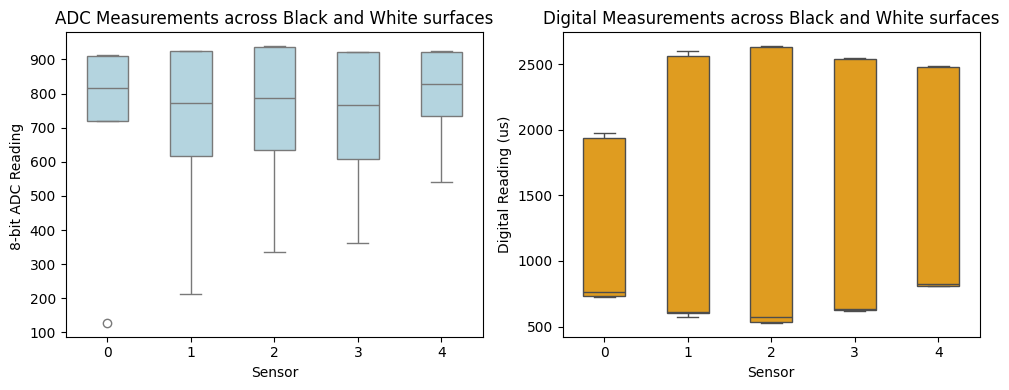

In [ ]:
# @title

# We will use the following Python libraries:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Path to where the results are hosted online
# This loads the data into a Pandas dataframe
line_sensors = pd.read_csv('https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/ExampleData/LineSensor_Comparison.csv', sep=',')

# Take a look at how the data is stored (column headers)
#print( line_sensors )

# Split the data based on Technique
# There are other ways to investigate the data.
adc = line_sensors[ (line_sensors['Technique'] == 'ADC') ]
digital = line_sensors[ (line_sensors['Technique'] == 'Digital') ]

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.color_palette("pastel")

bplot1 = sns.boxplot(ax=axes[0], y='Reading', x='Sensor', data=adc, color="lightblue", width=0.5)
axes[0].set_title('ADC Measurements across Black and White surfaces')
axes[0].set_ylabel('10-bit ADC Reading ')

bplot2 = sns.boxplot(ax=axes[1], y='Reading', x='Sensor', data=digital, color="orange", width=0.5)
axes[1].set_title('Digital Measurements across Black and White surfaces')
axes[1].set_ylabel('Digital Reading (us)')

plt.tight_layout()
plt.show()


<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/exercise.png" align="left">  **Exercise:** Using the above code cell (click, "show code"), try altering the plot for the line sensor readings.  Investigate how different the data looks when calibration and normalisation is applied, following the same procedure used on the 3Pi+ robot (i.e., minimum, maximum, range).    

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/observation.png" align="left"> **Observations:** Note that, whilst we have collected data from the same sensors (`DN1`, `DN2`, etc), the sensor is being operated differently.  Therefore, we can see different performance depending on which read technique is applied.  

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/validate.png" align="left"> **Validate:** There is another hidden aspect to the performance of these sensors: the time it takes to conduct a measurement from the sensor.  Our prior knowledge is that an ADC read is relatively quick.  We also know from experience that the digital method can take several milliseconds to complete (relatively slow).  Collect data to plot the measurement time against different coloured (reflectivity) surfaces.

<img src="https://raw.githubusercontent.com/paulodowd/EMATM0054_53/main/Images/hypothesis.png" align="left">**Hypothesise:** Which of these sensor reading techniques has the best performance?  What prior understanding are you drawing on to make this prediction?  What task, problem or application (context) are you using when you formulate this prediction?  How might we test and measure this prediction or theory?